In [1]:
%pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks
!unzip -qq open-images-bus-trucks.zip
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 56.4 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
 82% 302M/367M [00:00<00:00, 860MB/s] 
100% 367M/367M [00:00<00:00, 700MB/s]


In [2]:
# set base directory where all images are stores
IMAGE_ROOT = 'images/images'
# load csv file containing metadata about the image
DF_RAW = pd.read_csv('df.csv')
# print the first 5 rows of the dataset
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

In [3]:
import cv2
# define a custom dataset class that will feed images and labels to the model
class OpenImages(Dataset):
  def __init__(self, df, image_folder=IMAGE_ROOT):
    self.root = image_folder
    self.df = df
    self.unique_images = df['ImageID'].unique()

  def __len__(self):
    # total number of images
    return len(self.unique_images)

  def __getitem__(self, ix):
    # get the image id
    image_id = self.unique_images[ix]
    # get the image filepath
    image_path = f'{self.root}/{image_id}.jpg'
    # read the image in BGR format(opencv default) and flip the color channels to RGB
    image = cv2.imread(image_path, 1)[...,::-1]
    # get the image shape
    h, w, _ = image.shape
    df = self.df.copy()
    # select  only rows for the current image
    df = df[df['ImageID'] == image_id]
    # extrct bounding boxes
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    # multiply the coordinates by w,h,w,h to convert them to pixel coordinates and cast to unsigned 16-bit ints and then to a list for easier handling
    boxes = (boxes * np.array([w, h, w, h])).astype(np.uint16).tolist()
    # extract class labels
    classes =df['LabelName'].values.tolist()
    # return one image and its corresponding bounding boxes and class names
    return image, boxes, classes, image_path

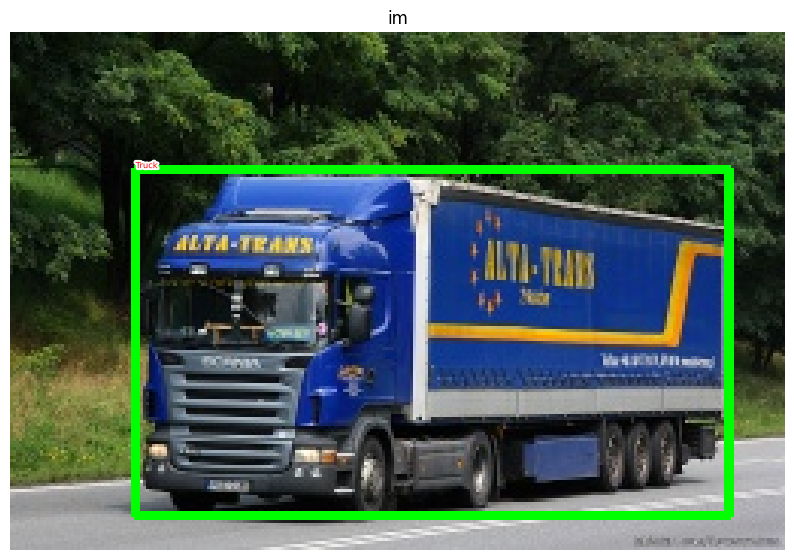

In [4]:
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

array([[[  5,  12,   5],
        [ 11,  18,  11],
        [  9,  19,  10],
        ...,
        [ 66,  89,  47],
        [ 69,  92,  48],
        [ 53,  76,  32]],

       [[  6,  13,   6],
        [  4,  11,   4],
        [ 14,  24,  15],
        ...,
        [ 44,  67,  25],
        [ 76,  99,  57],
        [ 90, 113,  69]],

       [[  8,  15,   8],
        [ 12,  19,  12],
        [ 19,  26,  19],
        ...,
        [ 69,  90,  49],
        [ 97, 118,  77],
        [ 52,  73,  32]],

       ...,

       [[166, 166, 168],
        [170, 170, 172],
        [167, 167, 169],
        ...,
        [149, 148, 156],
        [161, 160, 168],
        [183, 182, 190]],

       [[169, 169, 171],
        [172, 172, 174],
        [168, 168, 170],
        ...,
        [157, 156, 164],
        [166, 165, 173],
        [174, 173, 181]],

       [[163, 163, 165],
        [166, 166, 168],
        [164, 164, 166],
        ...,
        [174, 173, 181],
        [182, 181, 189],
        [180, 179, 187]]], dtype=uint8)
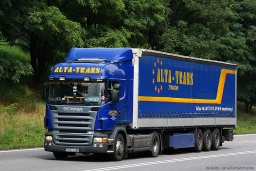

In [5]:
im

In [6]:
_

'images/images/00072b81abc72d21.jpg'

In [7]:
bbs

[[41, 45, 237, 159]]

In [8]:
clss

['Truck']

In [9]:
im.shape

(171, 256, 3)

In [10]:
# create a function that takes an image and outputs a filtered list of bounding boxes that likely contain objects, the region proposals RCNN will later classify
# image -> selective search -> region proposals -> filter -> list of boxes
def extract_candidates(img):
  # run selective search on a single image
  img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  # get total image area
  img_area = np.prod(img.shape[:2])
  # get region proposals as bounding boxes
  # initialize list of candidates to hold all valid bounding boxes after filtering
  candidates = []
  # loop thru all regions
  for r in regions:
    # skip duplicates
    if r['rect'] in candidates: continue
    # extract bounding box coordinates
    x, y, w, h = r['rect'] # each regions rect is a tuple (x,y,w,h)
    # skip tiny regions that cover less that 5% of the image area, they are unlikely to contain full objects
    if w * h < (0.05*img_area): continue
    # skip regions the size of the entire image
    if w * h > (1*img_area): continue
    # keep valid regions
    candidates.append(r['rect'])
  #return a list of bounding boxes, each as (x,y,w,h)
  return candidates

In [11]:
def extract_iou(boxA, boxB, epsilon=1e-5): # epsilon: a tiny number added to avoid division by zero errors
  # two bounding boxes in pixel coordinates (z1,y1,x2,y2)

  # find overlap corners, the overlapping region
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  # compute the overlap size
  width = (x2 - x1)
  height = (y2 - y1)
  if (width<0) or (height<0):
    return 0.0
  # compute the intersection area
  area_overlap = width * height
  # compute each boxes area
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  # compute union area - subtract the overlap once to avoid double-counting
  area_combined = area_a + area_b - area_overlap
  # final iou
  iou = area_overlap / (area_combined + epsilon)
  return iou

array([[[254, 255, 249],
        [255, 255, 251],
        [255, 255, 255],
        ...,
        [150, 148, 136],
        [149, 147, 135],
        [149, 147, 135]],

       [[255, 255, 250],
        [253, 254, 249],
        [254, 254, 254],
        ...,
        [150, 148, 136],
        [153, 151, 139],
        [155, 153, 141]],

       [[254, 255, 250],
        [255, 255, 253],
        [255, 255, 255],
        ...,
        [144, 140, 128],
        [141, 137, 125],
        [139, 135, 123]],

       ...,

       [[141, 143, 140],
        [130, 132, 129],
        [139, 139, 137],
        ...,
        [111, 118,  77],
        [ 86,  93,  51],
        [131, 138,  96]],

       [[158, 160, 159],
        [153, 155, 152],
        [164, 164, 162],
        ...,
        [ 91,  98,  57],
        [ 65,  72,  30],
        [133, 140,  96]],

       [[146, 148, 147],
        [119, 121, 120],
        [112, 112, 110],
        ...,
        [124, 131,  89],
        [ 82,  89,  47],
        [175, 182, 138]]], dtype=uint8)
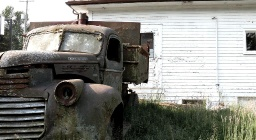

In [12]:
ds[8][0]

In [13]:
# initialize empty lists to store results
# file paths, gorund truth bounding boxes, classes, of objects, offset, region proposal locations, and iou
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
# first 500 images traversed
N = 500
# loop thru the dataset
for ix, (im, bbs, labels, fpath) in enumerate(ds):
   # ensure we only process 500 images
    if(ix==N):
        break
    # get the image height and width
    H, W, _ = im.shape
    # generate region proposals
    candidates = extract_candidates(im)
    # convert the region proposals for iou calculation
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    # initialize lists to stor iou for each candidate, region proposal location, bounding box offset and class corresponding to every candidate for each image
    ious, rois, clss, deltas = [], [], [], []
    # store the ious of all candidates with respect to all ground truths for an image, bbs=ground truth
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    # loop thru each candidate and store the values of a candidate
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        # cx=XMin, cy=YMin, cX=XMax, cY=YMax
        candidate_ious = ious[jx]
        #find the index of a candidate that has the highest IoU
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # if overlap is above 0.3, treat as an object region
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        # else label as backgorund
        else : clss.append('background')
        # delta = how far the ground truth box is from the candidate box, normalized by image size
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [14]:
# label encoding step
# CLSS is a nested list, flatten it to a long list. then warp it into a dataframe
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
# mapping eg, 'Bus': 0
label2target = {l:t for t, l in enumerate(targets['label'].unique())}
# inverts mapping, eg, 0: 'Bus'
target2label = {t:l for l, t in label2target.items()}
# extract the numeric ID of the class 'background'
background_class = label2target['background']

targets.head()

In [15]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
  # convert image to tensor and change shape from (H,W,C) to (C,H,W)
  img = torch.tensor(img).permute(2,0,1)
  # apply defined normalization
  img = normalize(img)
  return img.to(device).float()

def decode(_y):
  # computes the maximum valus along the last dimension
  _, preds = _y.max(-1)
  # returns the class index with the highest probability
  return preds

In [16]:
# class for the dataset that prepares region crops and labels in a format that can go directly into the RCNN model
class RCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas, gtbbs):
    # list of image file paths
    self.fpaths = fpaths
    # ground-truth boxes for each image
    self.gtbbs = gtbbs
    # region proposals(relative coordinates)
    self.rois = rois
    # list of class names per region
    self.labels = labels
    # the regression targets per region, how to move canditate to ground truth
    self.deltas = deltas

  def __len__(self):
    # number of images in the dataset
    return len(self.fpaths)

  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    # losd an image
    image = cv2.imread(fpath, 1)[...,::-1]
    H, W, _ = image.shape
    # sh will help convert relative coordinates (0,1) to pixel coordinates
    sh = np.array([W,H,W,H])
    gtbbs = self.gtbbs[ix]
    rois = self.rois[ix]
    bbs = (np.array(rois)*sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    # crop each region, this is the input that will be fed into the CNN
    crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
    return image, crops, bbs, labels, deltas, gtbbs, fpath

  def collate_fn(self, batch):
    # initialize empty lists for batch data
    input, rois, rixs, labels, deltas = [], [], [], [], []
    # loop thru samples in the batch
    for ix in range(len(batch)):
      image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_f_path = batch[ix]
      # resize and preprocess each crop
      crops = [cv2.resize(crop, (224,224)) for crop in crops]
      # divide by 255 to scale pixel values
      crops = [preprocess_image(np.array(crop)/255.)[None] for crop in crops]
      input.extend(crops) # Corrected to extend with crops
      labels.extend(image_labels) # Added to extend labels
      deltas.extend(image_deltas) # Added to extend deltas

    # convert to tensors
    input = torch.cat(input).to(device)
    labels = torch.Tensor([label2target[l] for l in labels]).long().to(device) # Corrected labels to use label2target
    deltas = torch.Tensor(deltas).float().to(device)
    return input, labels, deltas

In [17]:
# splitting data 90% for training
n_train = 9*len(FPATHS)//10
# create training and testing datasets
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
# collate_fn tells pytorch how to merge samples into a batch
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [18]:
# load a pretrainied model
vgg_backbone = models.vgg16(pretrained=True)
# remove the classifier head, RCNN doesnt need the ImageNet classification head
# it will use its own fully connected layers for region recognition and bounding box regression
# the line below replaces the classifier with an empty sequential container
vgg_backbone.classifier = nn.Sequential()
# freeze all backbone weights
for param in vgg_backbone.parameters():
  param.requires_grad = False
vgg_backbone.eval().to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 64.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # feature dimensiality
    feature_dim = 25088
    # feature extraction backbone
    self.backbone = vgg_backbone
    # classification head, a fully connected layer that maps features to class scores
    self.cls_score = nn.Linear(feature_dim, len(label2target))
    # bounding box regression head, predicts 4 values per propoal region
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 4),
        # keeps outputs in range (-1,1) to stabalize training
        nn.Tanh()
    )
    # loss for classification
    self.cel = nn.CrossEntropyLoss()
    # loss for bouding box regression
    self.sl1 = nn.L1Loss()

  def forward(self, input):
    feat = self.backbone(input)
    cls_score = self.cls_score(feat)
    bbox = self.bbox(feat)
    return cls_score, bbox

  def calc_loss(self, probs, _deltas, labels, deltas):
    # probs = class logits from cls_score
    # _delatas = predicted bounding box corrections for self.bbox
    # labels = ground-truth class indeces (from label2target)
    # deltas = ground-truth bounding-box deltas

    # 1. classification loss
    detection_loss = self.cel(probs, labels)
    # 2. filter out background boxes... we compute regression loss for non-background regions
    ixs, = torch.where(labels != 0)
    _deltas = _deltas[ixs]
    # 3. bounding box regression loss
    # lmb used to scale regression loss
    self.lmb = 10.0
    if len(ixs) > 0:
      regression_loss = self.sl1(_deltas, deltas[ixs])
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
    else:
      # handle edge cases... if not non-background samples exist in the batch, skip the regression loss to avoid errors
      regression_loss = 0
      return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [20]:
def train_batch(inputs, model, optimizer, criterion):
  input, clss, deltas = inputs
  # set model into training mode
  model.train()
  # clear any gradients stored from the previous batch
  optimizer.zero_grad()
  # do  a forward pass... predicted class scores, predicted bounding-box corrections
  _clss, _deltas = model(input)
  # compute loss
  # loss= total loss combined, then classification loss, then bounding box regression loss
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
  # compute batch accuracy... decode(_clss) converts predicted logits to class indices using argmax
  # then we check which ones match the ground truth -> gives a boolen vector
  accs = clss == decode(_clss)
  # backpropagation - computes gradients of all trainable parameters
  loss.backward()
  # update model weights using the gradients computed in backpropagation
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [21]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
  input, clss, deltas = inputs
  with torch.no_grad():
    # switch model to evaluation mode, dropout layers turned off
    model.eval()
    # do a forward pass
    _clss, _deltas = model(input)
    # compute losses
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    # compute accuracy
    _, val_clss = _clss.max(-1) # gets both values and indices of the max score along the last dim
    # creates a boolean array of correct predictions
    accs = clss == val_clss
  return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [22]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [ ]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
    pos = (epoch + (ix+1)/_n)
    log.record(pos,
               trn_loss=loss.item(),
               trn_loc_loss = loc_loss,
               trn_regr_loss = regr_loss,
               trn_acc=accs.mean(),
               end='\r')
    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
      _clss, _deltas, loss, \
      loc_loss, regr_loss, accs = validate_batch(inputs, rcnn, criterion)
      pos = (epoch + (ix+1)/_n)
      log.record(pos, val_loss=loss.item(),
                 val_loc_loss=loc_loss,
                 val_acc=accs.mean(), end='\r')

# plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

/tmp/ipython-input-2482436808.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 2.400  val_loss: 1.713  val_loc_loss: 0.657  val_acc: 0.776  (9115.96s - 9875.63s remaining)

In [ ]:
import matplotlib.pyplot as plt
# function to make predictions
def test_predictions(filename, show_output=True):
  # read image and convert color channels to RGB
  img = np.array(cv2.imread(filename, 1)[...,::-1])
  # gennerate candidate regions
  candidates = extract_candidates(img)
  candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
  # crop, resize and preprocess each candidate
  input = []
  for candidate in candidates:
    x,y,X,Y = candidate
    crop = cv2.resize(img[y:Y,x:X], (224,224))
    input.append(preprocess_image(crop/255.)[None])
  input = torch.cat(input).to(device)
  # inference... forward pass
  with torch.no_grad():
    rcnn.eval()
    # pass all candidate crops thru the RCNN model
    probs, deltas = rcnn(input)
    # convert logits to probabilities
    probs = torch.nn.functional.softmax(probs, -1)
    confs, clss = torch.max(probs, -1)
  candidates = np.array(candidates)
  confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

  # filter and refine predictions
  # remove any region classified as background class
  ixs = clss !=background_class
  confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
  # adjust boxes using predicted deltas
  bbs = (candidates + deltas).astype(np.uint16)
  # apply non-maximum supression... removes duplicate or overlapping boxes, keepingonly the most confident per object
  ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
  confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  # handle edge cases, if there is only one prediction, reshape tensors for consistency
  # if there are no predictions, return background or skip shpwing the image
  if len(ixs) == 1:
    confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  if len(confs) == 0 and not show_output:
    return (0,0,224,224), 'background', 0
  if len(confs) > 0:
    # choose the best prediction-highest confidence
    best_pred = np.argmax(confs)
    # get the confidence value
    best_conf = np.max(confs)
    # get the bounding box coordinates
    best_bb = bbs[best_pred]
    x,y,X,Y = best_bb
  # visualization
  _, ax = plt.subplots(1, 2, figsize=(20,10))
  show(img, ax=ax[0])
  ax[0].grid(False)
  ax[0].set_title('original image')
  if len(confs) == 0:
    ax[1].imshow(img)
    ax[1].set_title('no objects')
    plt.show()
    return
  ax[1].set_title(target2label[clss[best_pred]])
  show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
  plt.show()
  return (x,y,X,Y),target2label[clss[best_pred]],best_conf

In [ ]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)